In [2]:
import matplotlib.pyplot as plt
import nltk
import pandas as pd

from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [67]:
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Variation in Claims
This notebook investigates the variation of the generated claims.

In [19]:
# loading the claims data
claim_df = pd.read_csv("claims.csv", keep_default_na=False)

# ordering by level of detail
ordered_levels = ["None", "Low", "Medium", "High"]
claim_df["Detail level"] = pd.Categorical(
    claim_df["Detail level"],
    categories=ordered_levels,
    ordered=True
)

claim_df.head()

,Detail level,Claim,Soft/hard,Color,Annotator
0,High,Excited to apply for position,Soft,Orange,aksv
1,High,Studying Data Science at the IT University,Hard,Green,aksv
2,High,Eager to apply analytical and technical skills,Soft,Orange,aksv
3,High,1.5 years as student data analyst in the medic...,Hard,Green,aksv
4,High,Strong skills in Python,Hard,Green,aksv


Number of claims for each detail level:

In [6]:
claim_df["Detail level"].value_counts()

Detail level
High      92
None      90
Low       85
Medium    80
Name: count, dtype: int64

Number of claims for each type of claim (soft/hard):

In [7]:
claim_df["Soft/hard"].value_counts()

Soft/hard
Soft    215
Hard    132
Name: count, dtype: int64

Number of claims per combination of detail level and claim type (soft/hard):

In [8]:
claim_df["level_type"] = claim_df["Detail level"] + " " + claim_df["Soft/hard"]
claim_df["level_type"].value_counts()

level_type
Low Soft       64
None Soft      57
Medium Soft    51
High Hard      49
High Soft      43
None Hard      33
Medium Hard    29
Low Hard       21
Name: count, dtype: int64

Plotting proportion of soft and hard claims per detail level as a stacked bar chart:

C:\Users\sebas\AppData\Local\Temp\ipykernel_16392\3113407194.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = claim_df.groupby(['Detail level', 'Soft/hard']).size().unstack(fill_value=0)


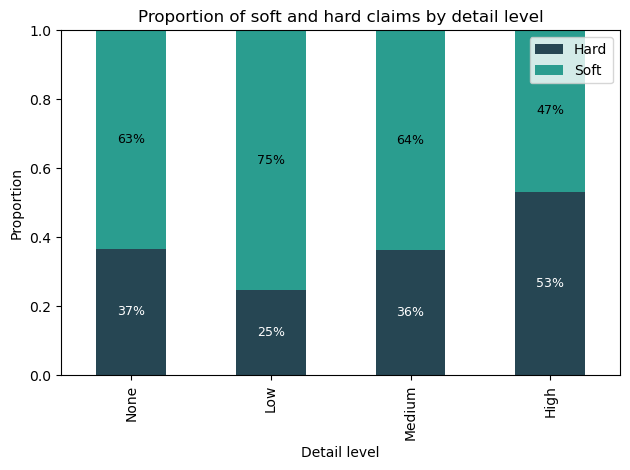

In [20]:
# counting occurrences of combinations of detail level and soft/hard
counts = claim_df.groupby(['Detail level', 'Soft/hard']).size().unstack(fill_value=0)

# converting the counts to proportions
proportions = counts.div(counts.sum(axis=1), axis=0)

# plotting the stacked bar chart
colors = ["#264653", "#2a9d8f"]
ax = proportions.plot(kind='bar', stacked=True, color=colors)

# adding labels to each stack
for i, detail_level in enumerate(proportions.index):
    bottom = 0
    for j, soft_hard in enumerate(proportions.columns):
        value = proportions.loc[detail_level, soft_hard]
        font_color = 'white' if j == 0 else 'black'
        ax.text(i, bottom + value / 2, 
                f"{value:.0%}", 
                ha='center', va='center', 
                fontsize=9, color=font_color
                )
        bottom += value

plt.ylabel('Proportion')
plt.title('Proportion of soft and hard claims by detail level')
plt.legend(loc='upper right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

Number of claims per annotator:

In [6]:
claim_df["Annotater"].value_counts()

Annotater
idwe    83
aksv    81
swae    76
bhei    65
Name: count, dtype: int64

#### Analyzing the contents of the claims

In [ ]:
# function to stem and tokenize text
def stem_and_tokenize(text):
    stemmer = PorterStemmer()
    words = text.split(" ")  # Tokenize the text
    stemmed_tokens = [stemmer.stem(word.lower()) for word in words]  # Lemmatize each token
    return stemmed_tokens

In [75]:
def count_stem_freqs(df, text_col, top_n):
    # tokenize and stem the "Claim" column
    df["Stemmed_Claims"] = df[f"{text_col}"].apply(lambda x: stem_and_tokenize(x))

    # flatten the list of stemmed words
    all_stemmed_words = [word for tokens in df['Stemmed_Claims'] for word in tokens]

    # removing stop words from the list of all stemmed words
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in all_stemmed_words if word.lower() not in stop_words]

    # counting the occurence of each word
    word_counts = Counter(filtered_words)

    # sorting dict and returning top n words by frequency
    top_n = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True)[:top_n])

    return top_n

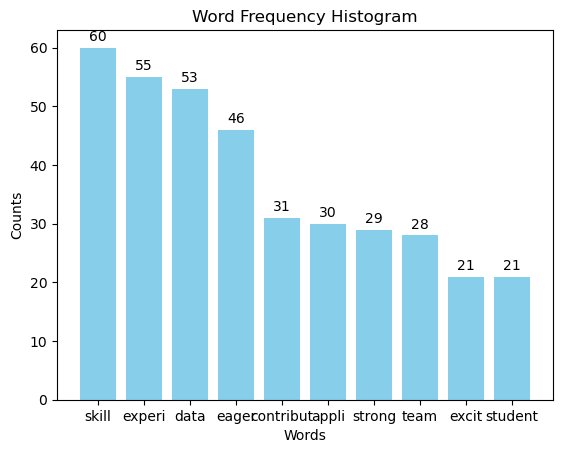

In [105]:
top_n = 10
top_10_words_overall = count_stem_freqs(claim_df, "Claim", top_n)

words, counts = zip(*top_10_words_overall.items())

# Plot the histogram
bars = plt.bar(words, counts, color='skyblue')
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Word Frequency Histogram')
plt.bar_label(bars, fmt='%d', padding=3)
plt.show()

Top 10 word stems for each level of detail:

C:\Users\sebas\AppData\Local\Temp\ipykernel_32968\775763399.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Stemmed_Claims"] = df[f"{text_col}"].apply(lambda x: stem_and_tokenize(x))


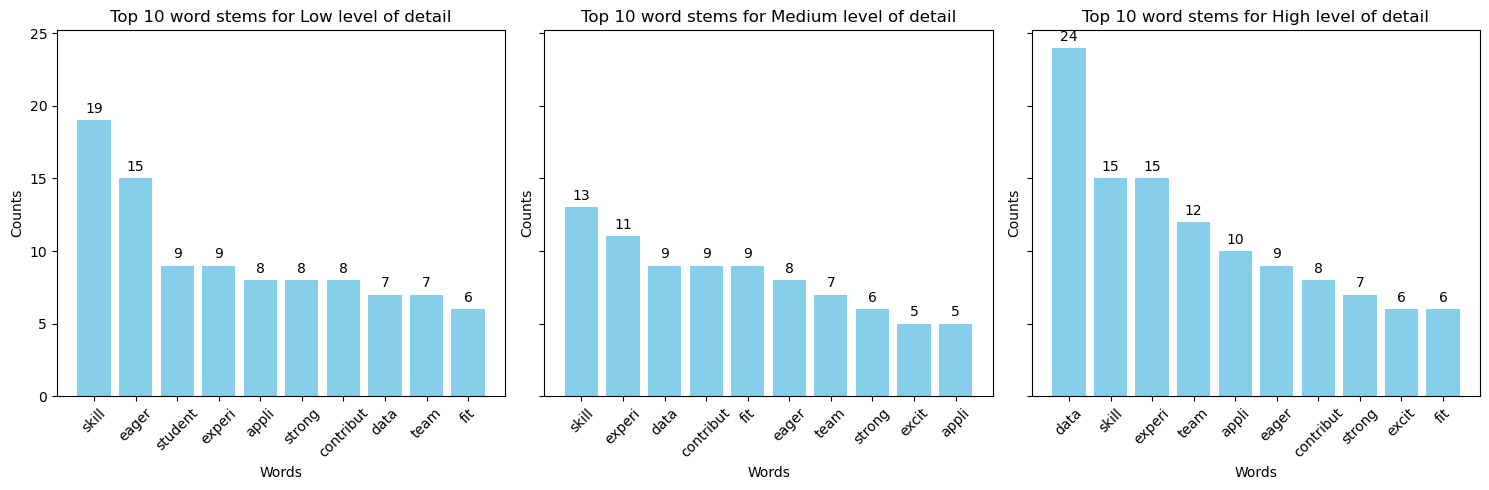

In [106]:
levels = ["Low", "Medium", "High"]
top_n = 10

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, level in enumerate(levels):
    level_df = claim_df[claim_df["Detail level"] == f"{level}"]
    top_10_words = count_stem_freqs(level_df, "Claim", top_n)
    
    words, counts = zip(*top_10_words.items())
    
    bars = axes[i].bar(words, counts, color='skyblue')
    axes[i].bar(words, counts, color='skyblue')
    axes[i].set_title(f"Top {top_n} word stems for {level} level of detail")
    axes[i].set_xlabel("Words")
    axes[i].set_ylabel("Counts")
    axes[i].tick_params(axis='x', rotation=45)  
    axes[i].bar_label(bars, fmt='%d', padding=3)

plt.tight_layout()
plt.show()

Top 10 word stems for each claim type (soft/hard):

C:\Users\sebas\AppData\Local\Temp\ipykernel_32968\775763399.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Stemmed_Claims"] = df[f"{text_col}"].apply(lambda x: stem_and_tokenize(x))


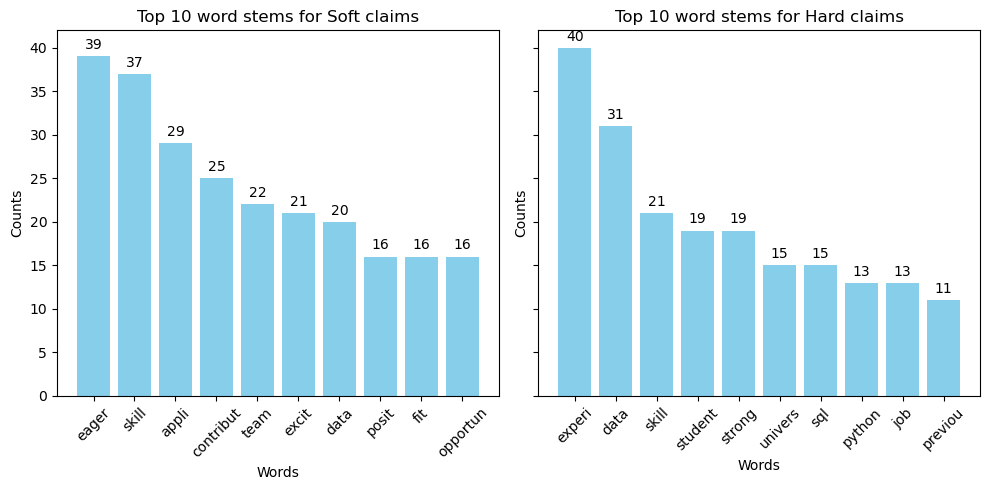

In [107]:
types = ["Soft", "Hard"]
top_n = 10

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for i, type in enumerate(types):
    type_df = claim_df[claim_df["Soft/hard"] == f"{type}"]
    top_10_words = count_stem_freqs(type_df, "Claim", top_n)
    
    words, counts = zip(*top_10_words.items())
    
    bars = axes[i].bar(words, counts, color='skyblue')
    axes[i].bar(words, counts, color='skyblue')
    axes[i].set_title(f"Top {top_n} word stems for {type} claims")
    axes[i].set_xlabel("Words")
    axes[i].set_ylabel("Counts")
    axes[i].tick_params(axis='x', rotation=45)  
    axes[i].bar_label(bars, fmt='%d', padding=3)

plt.tight_layout()
plt.show()